In [750]:
import yt
import unyt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [751]:
import os
import sys

# Required to guarantee that the 'src' module is accessible when
# this file is run directly.
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [752]:
from typing import Any, Callable, List, Tuple

In [753]:
from src.calc import std_dev, overdensity, mass_function, press_schechter, rho_bar
from src.fitting import fits
from src.plotting import Plotter

In [754]:
from src.util.init import setup

CONF="configs/press_schechter.yaml"

d = setup.setup([CONF])

caches:
  use_fits_cache: true
  use_masses_cache: true
  use_overdensities_cache: true
  use_press_schechter_cache: false
  use_rho_bar_0_cache: true
  use_rho_bar_cache: true
  use_sphere_samples: true
  use_standard_deviation_cache: false
  use_total_cache: true
datatypes:
  groups: false
  halos_h5: true
  rockstar: false
  snapshots: true
from_z: 6
plotting:
  dirs:
    compared: '{}/{}/compared/'
    extrapolated_gaussian_fit: '{}/{}/extrapolated_gaussian_fit/'
    gaussian_fit: '{}/{}/gaussian_fit/'
    mass_function: '{}/{}/mass_function/'
    n_gaussian_fit: '{}/{}/n_gaussian_fit/'
    numerical_mass_function: '{}/{}/numerical_mass_function/{}/'
    overdensity: '{}/{}/deltas/'
    press_schechter: '{}/{}/press_schechter/'
    root: ../plots/
    skewed_gaussian_fit: '{}/{}/skewed_gaussian_fit/'
    std_dev: '{}/{}/std_dev/'
    total: '{}/{}/total_mass_function/'
  fitting:
    num_n_gaussian_fits: 10
  pattern:
    compared_analytic: analytic_mass_function_comparison_z{:.2f}

In [755]:
from src.util.constants import DELTA_CRIT

In [756]:
def analytic_press_schechter(avg_den: float, masses: List[float], sigmas: List[float]):
    frac = np.abs(sigmas / masses).value

    press_schechter = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
        avg_den / masses) * frac * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))

    return press_schechter

In [757]:
from scipy import integrate
from src.fitting import funcs

def numerical_mass_function(avg_den: float, radii: List[float], masses: List[List[float]], fitting_func: Callable, func_params):

    F = []

    for i in range(len(radii)):
        popt = func_params[i]

        def f(x):
            y = fitting_func(x, *popt)
            return funcs.filter_val(y)

        integrand, err = integrate.quad(f, DELTA_CRIT, np.inf)
        F.append(integrand)

    dF_dR = np.abs(np.gradient(F, radii))

    dR_dM = np.abs(np.gradient(radii, masses))

    dF_dM = dF_dR * dR_dM

    dn_dM = dF_dM * avg_den / masses

    return dn_dM


In [758]:
def _mass_function(x, y, label: str = None, fig=None):
    if len(x) == 0 or len(y) == 0:
        print("Attempting to plot empty data!")
        return

    autosave = fig is None
    if autosave:
        fig = plt.figure()
    ax = fig.gca()

    # Filter values:
    y = np.round(y, decimals=100)
    non_zero = (y != 0)
    y = y[non_zero]
    x = x[non_zero]

    ax.plot(x, y, label=label)
    ax.set_xscale("log")
    ax.set_yscale("log")

    if label is not None:
        ax.legend()

    ax.set_xlabel("M ($M_\odot$/h)")
    ax.set_ylabel("$\phi=\\frac{d n}{d M}$")

    return fig


In [759]:
from src.util.enum import DataType

In [760]:
sim_name = d.config.sim_data.simulation_names[0]

In [761]:
sd = std_dev.StandardDeviation(d, DataType.SNAPSHOT, sim_name)

In [762]:
rb = rho_bar.RhoBar(d, DataType.SNAPSHOT, sim_name)

In [763]:
fitter = fits.Fits(d, DataType.SNAPSHOT, sim_name)

In [764]:
plotter = Plotter(d, DataType.SNAPSHOT, sim_name)

In [765]:
ods = overdensity.Overdensity(d, DataType.SNAPSHOT, sim_name)

In [766]:
mf = mass_function.MassFunction(d, DataType.H5, sim_name)

In [767]:
ps = press_schechter.PressSchechter(d, DataType.SNAPSHOT, sim_name)

In [768]:
from src.util.halos import halo_finder

finder = halo_finder.HalosFinder(DataType.SNAPSHOT, d.config.sim_data.root, sim_name)

hfs = finder.filter_data_files([0, 6, 99])

In [769]:
hfs

['/disk12/legacy/GVD_C700_l1600n2048_SLEGAC/dm_gadget/data/snapdir_101/snapshot_101.0.hdf5',
 '/disk12/legacy/GVD_C700_l1600n2048_SLEGAC/dm_gadget/data/snapdir_037/snapshot_037.0.hdf5',
 '/disk12/legacy/GVD_C700_l1600n2048_SLEGAC/dm_gadget/data/snapdir_000/snapshot_000.0.hdf5']

In [770]:
hf_0, hf_6, hf_99 = hfs

In [771]:
ds = d.dataset_cache.load(hf_0)
z = ds.current_redshift

In [772]:
d.config.max_radius = 100
masses, sigmas = sd.masses_sigmas(
                hf_0, from_fit=False)

In [773]:
avg_den_0 = rb.rho_bar(hf_0)

In [774]:
from src.util import units as u
ps_fit = analytic_press_schechter(avg_den_0, masses, sigmas).to(1 / u.volume(ds))

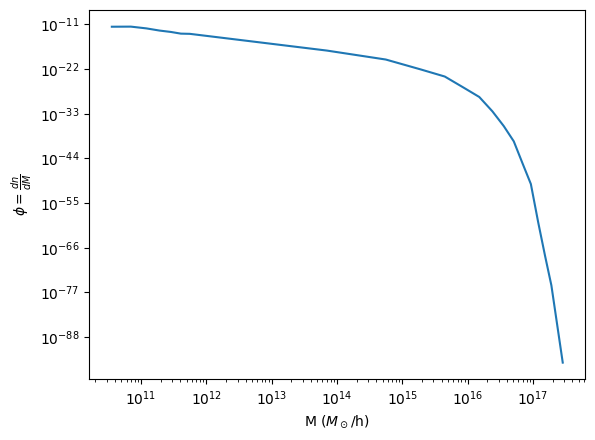

In [775]:
fig = plt.figure()

_mass_function(masses, ps_fit, fig=fig);

# STD DEVS EXTRAPOLATION

In [776]:
stds_99 = sd.extrapolated(99, 0, from_fit=False);

In [777]:
stds_6 = sd.extrapolated(6, 0, from_fit=False)

In [778]:
avg_den_6 = rb.rho_bar(hf_6)

In [779]:
avg_den_99 = rb.rho_bar(hf_99)

In [780]:
ps_fit_99 = analytic_press_schechter(avg_den_99, masses, stds_99).to(1 / u.volume(ds))

In [781]:
ps_fit_6 = analytic_press_schechter(avg_den_6, masses, stds_6).to(1 / u.volume(ds))

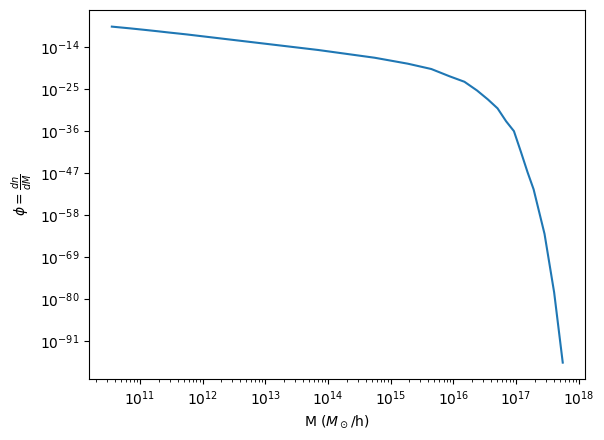

In [782]:
fig = plt.figure()

_mass_function(masses, ps_fit_6, fig=fig);

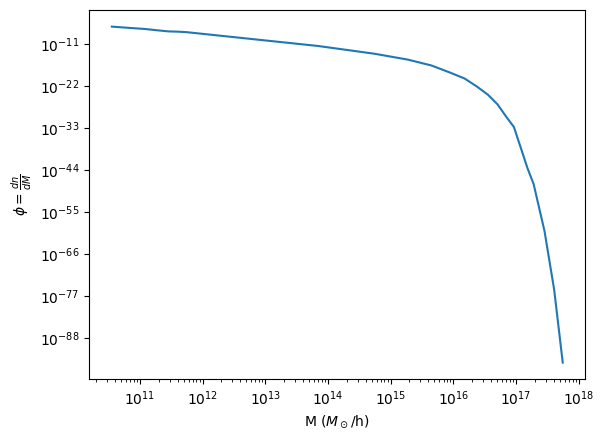

In [783]:
fig = plt.figure()

_mass_function(masses, ps_fit_99, fig=fig);

# Composite

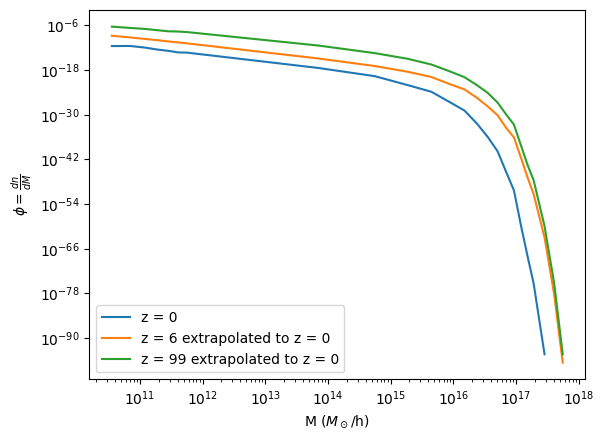

In [784]:
fig = plt.figure()

_mass_function(masses, ps_fit, fig=fig, label="z = 0");
_mass_function(masses, ps_fit_6, fig=fig, label="z = 6 extrapolated to z = 0");
_mass_function(masses, ps_fit_99, fig=fig, label="z = 99 extrapolated to z = 0");


In [785]:
fig.savefig("../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/extrapolated_press_schechters.png")

[-5.96798035e+02 -1.97013076e+02 -2.12129880e+02 -3.26885572e+02
 -3.41222610e+02 -4.82798546e+02 -3.10173281e+02 -3.50597488e+02
 -5.30353820e+02 -3.82258712e+03 -9.35048868e+03 -6.71038189e+04
 -4.77346459e+05 -8.65887132e+06 -1.67553312e+08 -4.66078222e+09
 -6.83487088e+11 -1.68599019e+14 -1.73882204e+18 -1.62465078e+21
 -1.00507280e+24 -2.48349208e+31 -6.00820399e+41 -5.90069959e+56] dimensionless


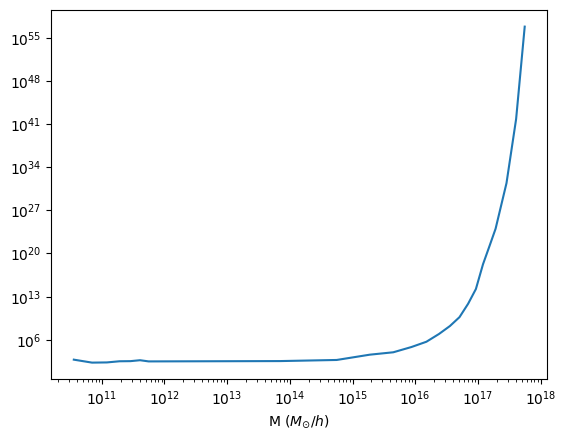

In [786]:
residual_0v6 = (ps_fit - ps_fit_6) / ps_fit

fig = plt.figure()
ax = fig.gca()

ax.plot(masses, abs(residual_0v6))
ax.set_xscale("log")
ax.set_xlabel("M ($M_{\odot}/h$)")
ax.set_yscale("log")

print(residual_0v6)

fig.savefig("../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals.png")

In [787]:
num_bins = d.config.sampling.num_hist_bins

# NUMERICAL MASS FUNCTIONS

In [788]:
numericals = {}

for func_name, fitting_func in fitter.fit_functions().items():
    # Set the fitting function to use
    plotter.func = fitting_func
    # Track the fitting parameters across radii
    func_params = []

    # Iterate over the radii
    radii = d.config.radii
    for radius in radii:

        # Calculate the overdensities at this sampling radius
        od = ods.calc_overdensities(hf_0, radius)

        # Get the fitting parameters to this overdensity
        fitter.setup_parameters(func_name)
        _, _, _, popt = fitter.calc_fit(
            z, radius, od, num_bins)

        # Track the fitting parameters
        func_params.append(popt)

    # Calculate the numerical mass function for this fit model
    numerical_mass_function = ps.numerical_mass_function(
        avg_den_0, radii, masses, fitting_func, func_params)
    
    numericals[func_name] = numerical_mass_function

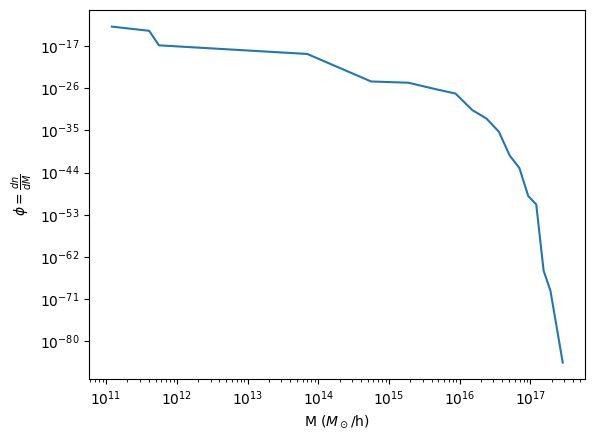

In [789]:
_mass_function(masses, numericals["gaussian"]);

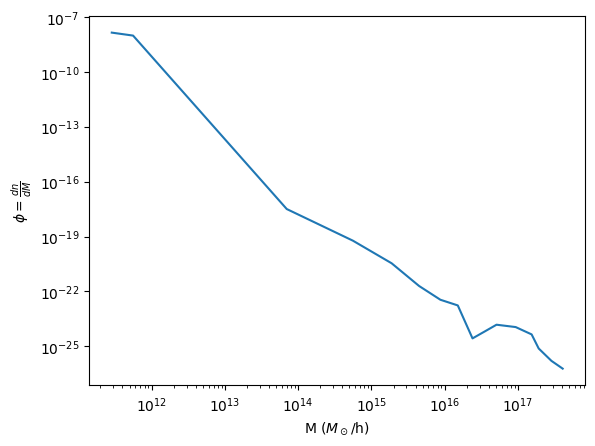

In [790]:
_mass_function(masses, numericals["skew_gaussian"]);

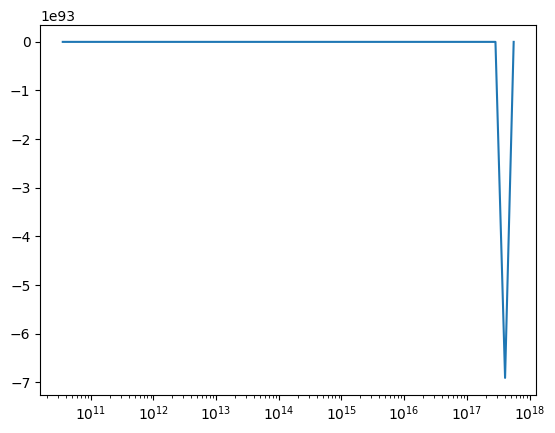

In [791]:
residuals_skew_ps = (ps_fit - numericals["skew_gaussian"]) / ps_fit

f = plt.figure()
a = f.gca()
a.plot(masses, residuals_skew_ps)
a.set_xscale("log")

# GET TOTAL HIST VALUES

In [792]:
import pickle

fname="/home/tstapleton/dissertation/data/GVD_C700_l1600n2048_SLEGAC/halos_h5/total_hist/0.0.pickle"
with open(fname, "rb") as f:
    tup = pickle.load(f)

total_hist, total_bins = tup

In [793]:
total_bins

array([7.54300000e+10, 5.20446757e+13, 1.04013921e+14, 1.55983167e+14,
       2.07952413e+14, 2.59921658e+14, 3.11890904e+14, 3.63860150e+14,
       4.15829396e+14, 4.67798641e+14, 5.19767887e+14, 5.71737133e+14,
       6.23706378e+14, 6.75675624e+14, 7.27644870e+14, 7.79614116e+14,
       8.31583361e+14, 8.83552607e+14, 9.35521853e+14, 9.87491098e+14,
       1.03946034e+15, 1.09142959e+15, 1.14339884e+15, 1.19536808e+15,
       1.24733733e+15, 1.29930657e+15, 1.35127582e+15, 1.40324506e+15,
       1.45521431e+15, 1.50718356e+15, 1.55915280e+15, 1.61112205e+15,
       1.66309129e+15, 1.71506054e+15, 1.76702978e+15, 1.81899903e+15,
       1.87096828e+15, 1.92293752e+15, 1.97490677e+15, 2.02687601e+15,
       2.13081450e+15, 2.18278375e+15, 2.23475300e+15, 2.28672224e+15,
       2.33869149e+15, 2.44262998e+15, 2.49459922e+15, 2.54656847e+15,
       2.59853772e+15, 2.70247621e+15, 2.80641470e+15, 2.85838394e+15,
       3.74186112e+15, 4.05367659e+15, 5.14503075e+15])

In [794]:
min_total = min(total_bins)
max_total = max(total_bins)

In [795]:
min_idxs = np.where(masses < max_total)

In [796]:
residuals_skew_ps = residuals_skew_ps[min_idxs]
filtered_masses = masses[min_idxs]

In [797]:
# max_idxs = np.where(filtered_masses > min_total)
# residuals_skew_ps = residuals_skew_ps[max_idxs]
# filtered_masses = filtered_masses[max_idxs]

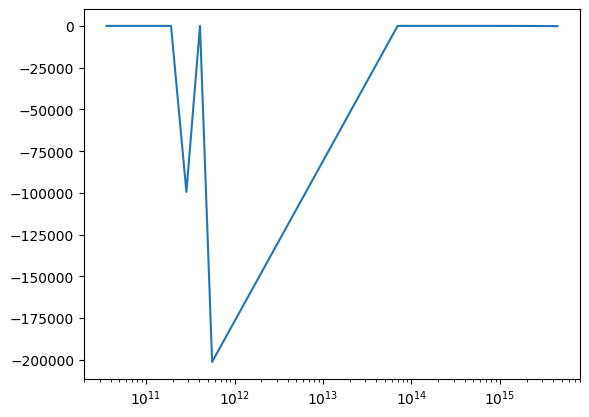

In [798]:
fig = plt.figure()
ax = fig.gca()

ax.plot(filtered_masses, residuals_skew_ps)
ax.set_xscale("log")

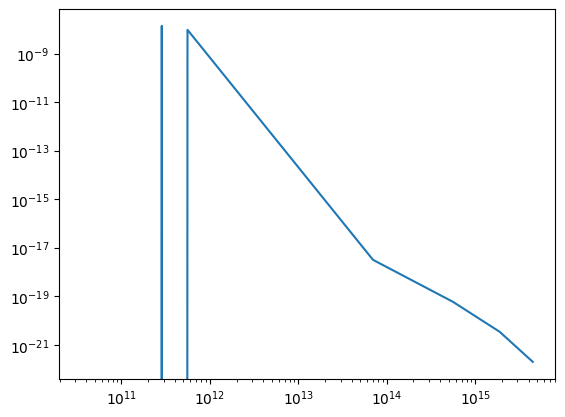

In [799]:
filtered_skew = numericals["skew_gaussian"][min_idxs]

fig = plt.figure()
ax = fig.gca()
ax.plot(filtered_masses, filtered_skew)
ax.set_xscale("log")
ax.set_yscale("log")

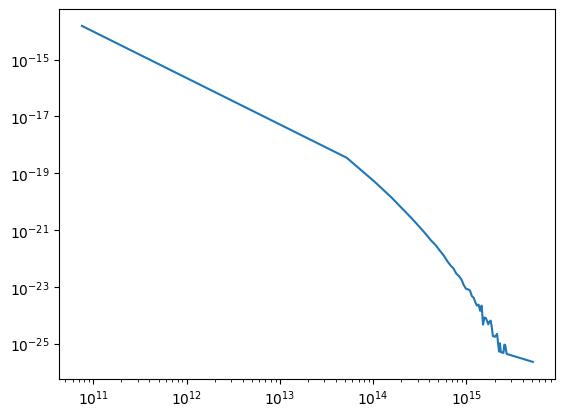

In [800]:
fig = plt.figure()
ax = fig.gca()
ax.plot(total_bins, total_hist / total_bins)
ax.set_xscale("log")
ax.set_yscale("log")

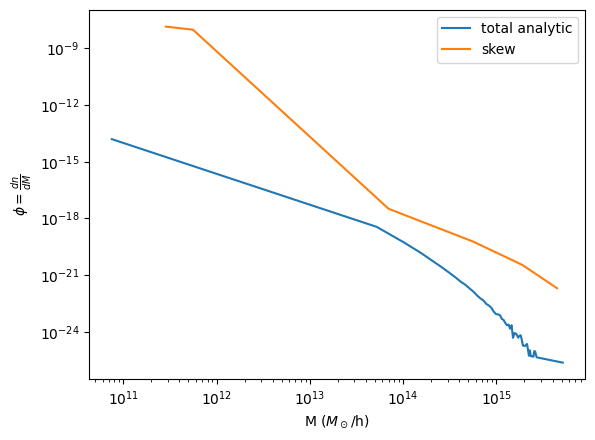

In [801]:
fig = plt.figure()
_mass_function(total_bins, total_hist / total_bins, label="total analytic", fig=fig);
_mass_function(filtered_masses, filtered_skew, label="skew", fig=fig);

In [802]:
numericals["skew_gaussian"]

unyt_array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00, 1.37558533e-08, 0.00000000e+00,
            9.47008744e-09, 3.16933703e-18, 5.91666030e-20,
            3.44924398e-21, 1.98228411e-22, 3.50661917e-23,
            1.71660895e-23, 2.71544007e-25, 6.74540250e-25,
            1.51774135e-24, 0.00000000e+00, 1.12836371e-24,
            0.00000000e+00, 4.48547874e-25, 7.61719177e-26,
            1.60721564e-26, 6.05836546e-27, 0.00000000e+00], 'h/Mpc**3')

# Compare Numerical Gaussian to PS:

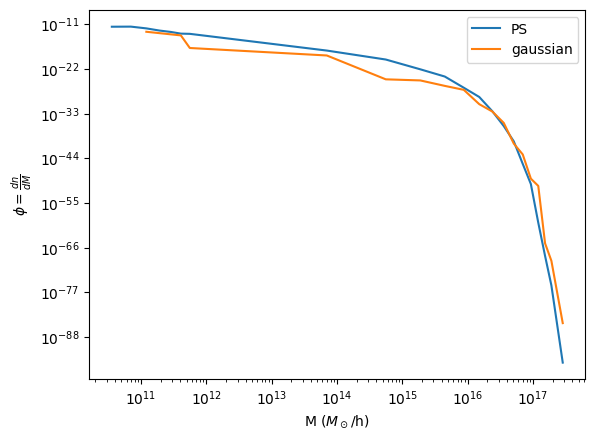

In [803]:
fig = plt.figure()
_mass_function(masses, ps_fit, label="PS", fig=fig);
_mass_function(masses, numericals["gaussian"], label="gaussian", fig=fig);

# FUDGING?

In [804]:
total_max_y = max(total_hist)
total_min_y = min(total_hist)
total_max_x = max(total_bins)
total_min_x = min(total_bins)
print("X BOUNDS=10^", np.log10(total_min_x), "< x < 10^", np.log10(total_max_x))
print("Y BOUNDS=", total_min_y, "< y <", total_max_y)

X BOUNDS=10^ 10.877544107715945 < x < 10^ 15.711387975091235
Y BOUNDS= 2.4414062499999994e-10 h**3/Mpc**3 < y < 0.0023911210937499995 h**3/Mpc**3


In [805]:
calibrated_ps = ps_fit / ps_fit[0] * total_hist[0]
calibrated_ps

unyt_array([1.15497127e-003, 1.22349847e-003, 4.50142589e-004,
            1.30935236e-004, 5.97194010e-005, 2.28777861e-005,
            2.03201148e-005, 1.53866686e-009, 9.48609060e-012,
            3.68372153e-014, 6.10302467e-016, 1.06969767e-018,
            5.54239386e-021, 1.61466686e-024, 3.73556638e-028,
            6.43393308e-032, 1.77869638e-037, 1.94817783e-042,
            5.82671593e-052, 3.59150947e-060, 1.99157976e-067,
            1.83587331e-086, 3.78579610e-112, 1.70988334e-145], 'h/Mpc**3')

In [806]:
valid_ranges_max = np.where(np.logical_and(calibrated_ps < total_max_y, calibrated_ps > total_min_y))

In [807]:
calibrated_ps = calibrated_ps[valid_ranges_max]
calibrated_masses = masses[valid_ranges_max]

In [808]:
valid_ranges_min = np.where(calibrated_ps > total_min_y)
calibrated_ps = calibrated_ps[valid_ranges_min]
calibrated_masses = calibrated_masses[valid_ranges_min]

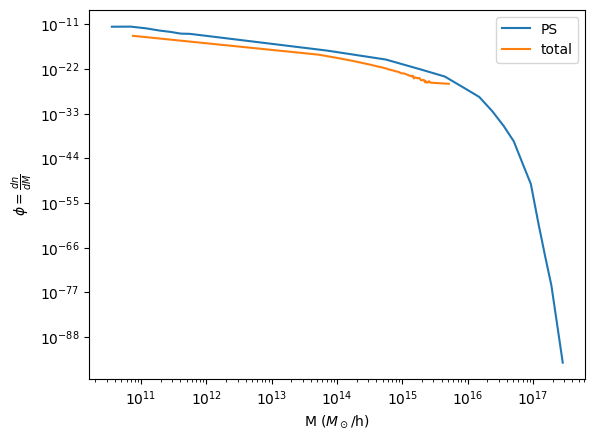

In [809]:
fig = plt.figure()
_mass_function(masses, ps_fit, fig=fig, label="PS");
_mass_function(total_bins, total_hist / total_bins, label="total", fig=fig);

In [810]:
masses

unyt_array([3.57490816e+10, 6.98224249e+10, 1.20653150e+11,
            1.91592734e+11, 2.85992653e+11, 4.07204382e+11,
            5.58579400e+11, 6.98224249e+13, 5.58579400e+14,
            1.88520547e+15, 4.46863520e+15, 8.72780312e+15,
            1.50816438e+16, 2.39490918e+16, 3.57490816e+16,
            5.09005478e+16, 6.98224249e+16, 9.29336476e+16,
            1.20653150e+17, 1.53399868e+17, 1.91592734e+17,
            2.85992653e+17, 4.07204382e+17, 5.58579400e+17], 'Msun/h')

In [811]:
sigmas

array([14.94155113,  3.25354208,  2.83985429,  4.27191945,  4.19072436,
        5.59081087,  2.98445027,  1.33863553,  0.79605145,  0.4933453 ,
        0.41145643,  0.32273131,  0.28137679,  0.23682987,  0.20739586,
        0.18593236,  0.16312915,  0.14861327,  0.12862674,  0.11666339,
        0.10848625,  0.09310919,  0.07991773,  0.0689652 ])

In [812]:
max_total_mass = max(total_bins)
relevant_idxs = np.where(masses < max_total_mass)

relevant_masses = masses[relevant_idxs]
relevant_sigmas = sigmas[relevant_idxs]

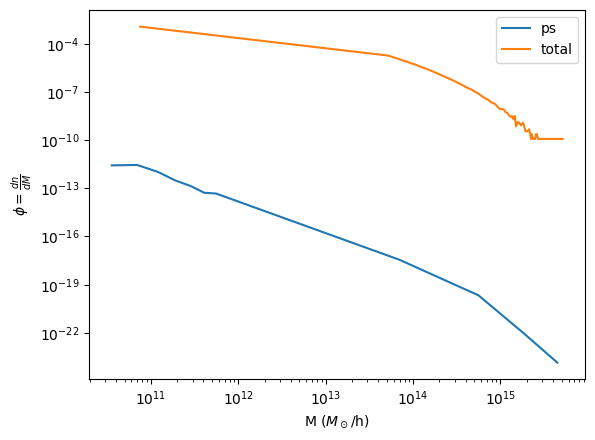

In [813]:
relevant_press = analytic_press_schechter(avg_den_0, relevant_masses, relevant_sigmas)

fig = plt.figure()
_mass_function(relevant_masses, relevant_press, fig=fig, label="ps");
_mass_function(total_bins, total_hist, fig=fig, label="total");

In [814]:
# frac = np.abs(sigmas / masses).value

# ps = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
#      avg_den_0 / masses) * frac * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))

# ps = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
#      avg_den_0 / masses) * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))
#     press_schechter = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
#         avg_den) * frac * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))

# print("FRAC")
# print(frac)
# print("PS")
# print(ps)

In [815]:
print(total_hist)

[2.39112109e-03 3.77312012e-05 1.06853027e-05 4.62402344e-06
 2.33032227e-06 1.37402344e-06 8.51562500e-07 5.61767578e-07
 3.74267578e-07 2.85400391e-07 2.01171875e-07 1.49658203e-07
 1.03515625e-07 7.95898437e-08 6.64062500e-08 4.68750000e-08
 4.12597656e-08 3.34472656e-08 2.24609375e-08 1.75781250e-08
 1.75781250e-08 1.68457031e-08 1.12304687e-08 1.02539062e-08
 7.32421875e-09 5.85937500e-09 6.59179687e-09 4.15039062e-09
 6.59179687e-09 1.46484375e-09 2.68554687e-09 2.68554687e-09
 2.19726562e-09 1.70898437e-09 2.19726562e-09 2.44140625e-09
 1.46484375e-09 7.32421875e-10 7.32421875e-10 7.32421875e-10
 9.76562500e-10 4.88281250e-10 2.44140625e-10 4.88281250e-10
 2.44140625e-10 2.44140625e-10 2.44140625e-10 4.88281250e-10
 4.88281250e-10 2.44140625e-10 2.44140625e-10 2.44140625e-10
 2.44140625e-10 2.44140625e-10 2.44140625e-10] h**3/Mpc**3


In [816]:
# ranges_min = np.where(ps > 1e-11)

In [817]:
ranges_min

(array([0, 1, 2, 3, 4, 5, 6, 7]),)

In [818]:
# fig=plt.figure()
# _mass_function(total_bins, total_hist, label="total", fig=fig);
# _mass_function(masses[ranges_min], ps[ranges_min], label="ps", fig=fig);

# Gaussian compared to PS

In [819]:
max_total_mass = max(total_bins)

In [820]:
ranges = np.where(masses < max_total_mass)
masses_r = masses[ranges]
ps_fit_r = ps_fit[ranges]
ps_fit_6_r = ps_fit_6[ranges]
ps_fit_99_r = ps_fit_99[ranges]
skew = numericals["skew_gaussian"][ranges]
gauss = numericals["gaussian"][ranges]

In [821]:
def residual(x1, y1, x2, y2, l1, l2, savename):
    fig = plt.figure()

    gs = fig.add_gridspec(2, 1)

    fig1 = fig.add_subfigure(gs[0,0])
    _mass_function(x1, y1, label=l1, fig=fig1);
    _mass_function(x2, y2, label=l2, fig=fig1);

    residual = (y1 - y2) / y1

    fig2 = fig.add_subfigure(gs[1,0])

    prev_ax=fig1.gca()
    ax = fig2.add_subplot(sharex=prev_ax)
    ax.plot(x1, abs(residual))
    ax.set_xscale("log")
    # ax.set_yscale("log")

    ax.set_xlabel("M ($M_{\odot}$/h)")
    ax.set_ylabel("residual = $\\frac{\phi_1-\phi_2}{\phi_1}$")

    fig.savefig(savename, bbox_inches='tight')

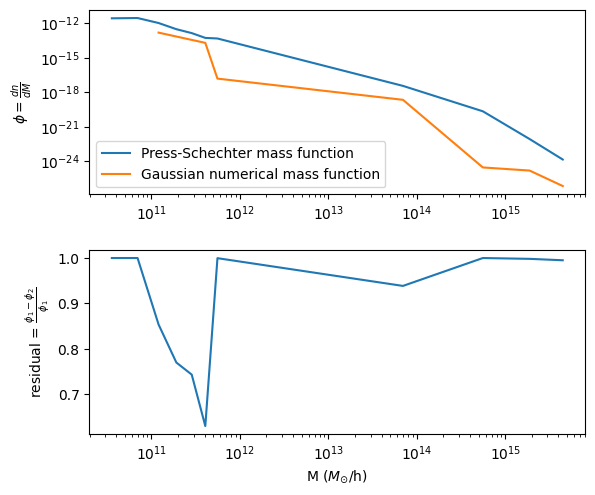

In [822]:
# residual(masses, ps_fit, masses, numericals["gaussian"], "Press-Schechter mass function", "Gaussian numerical mass function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_gaussian.png")
residual(masses_r, ps_fit_r, masses_r, gauss, "Press-Schechter mass function", "Gaussian numerical mass function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_gaussian.png")

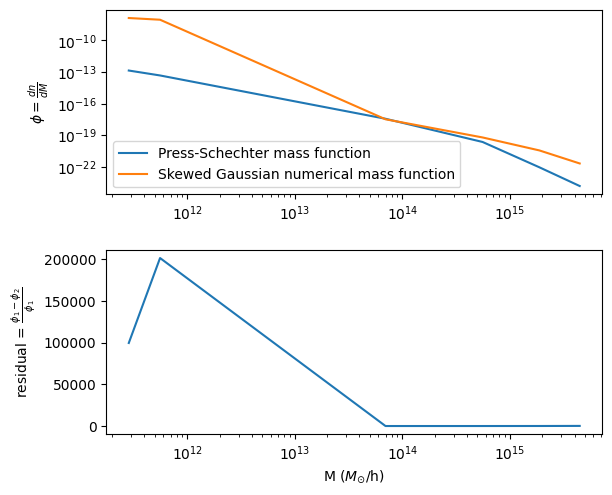

In [823]:
# residual(masses, ps_fit, masses, numericals["skew_gaussian"], "Press-Schechter mass function", "Skewed Gaussian numerical mass function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_skew_gaussian.png")

valid_skews = (skew != 0)
v_mass = masses_r[valid_skews]
v_ps_fit = ps_fit_r[valid_skews]
v_skew = skew[valid_skews]

residual(v_mass, v_ps_fit, v_mass, v_skew, "Press-Schechter mass function", "Skewed Gaussian numerical mass function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_skew_gaussian.png")

In [824]:
# residual(masses, numericals["skew_gaussian"], total_bins, total_hist, "Skewed Gaussian numerical mass function", "Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_skew_gaussian_total_z0.png")
# residual(masses_r, skew, total_bins, total_hist / total_bins, "Skewed Gaussian numerical mass function", "Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_skew_gaussian_total_z0.png")

In [825]:
volume = (ds.domain_width[0].to(u.length(ds)))**3

In [826]:
unhist = []
for h,b in zip(total_hist, total_bins):
    H = h * volume
    vals = [b for _ in range(round(H))]
    for a in vals:
        unhist.append(a)

unhist = unyt.unyt_array(unhist, u.mass(ds))

In [827]:
unhist

unyt_array([7.54300000e+10, 7.54300000e+10, 7.54300000e+10, ...,
            3.74186112e+15, 4.05367659e+15, 5.14503075e+15], 'Msun/h')

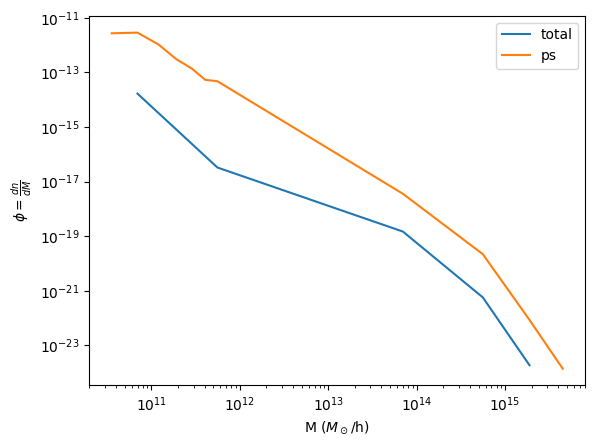

In [828]:
hist, bins = np.histogram(unhist, bins=masses_r)

fig = plt.figure()
_mass_function(bins[:-1], hist / volume / bins[:-1], fig=fig, label="total");
_mass_function(masses_r, ps_fit_r, fig=fig, label="ps");

In [829]:
ps_rescaled = ps_fit_r / ps_fit_r[0] * (hist / volume / bins[:-1])[0]

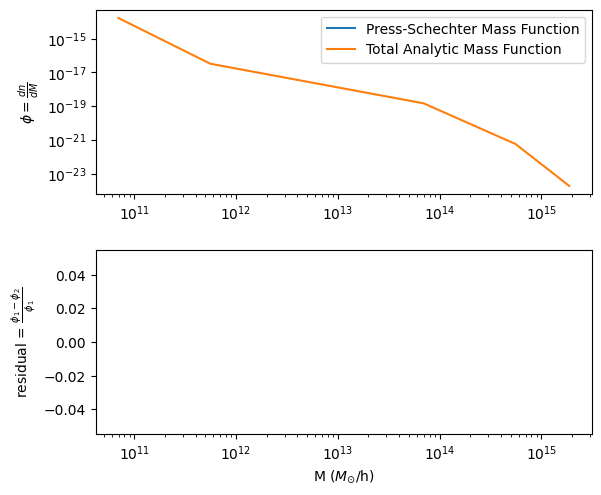

In [830]:
residual(masses_r[:-1], ps_rescaled[:-1], bins[:-1], hist / volume / bins[:-1], "Press-Schechter Mass Function", "Total Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residual_total_v_ps.png")

In [831]:
v_hist, v_bins = np.histogram(unhist, bins=v_mass)
tot = v_hist / volume / v_bins[:-1]

print(tot)
print(v_skew)
skew_rescale = v_skew / v_skew[0] * tot[0]

[0.00000000e+00 3.26276147e-17 1.47267297e-19 5.74240277e-22
 1.87660221e-24] h/Mpc**3
[1.37558533e-08 9.47008744e-09 3.16933703e-18 5.91666030e-20
 3.44924398e-21 1.98228411e-22] h/Mpc**3


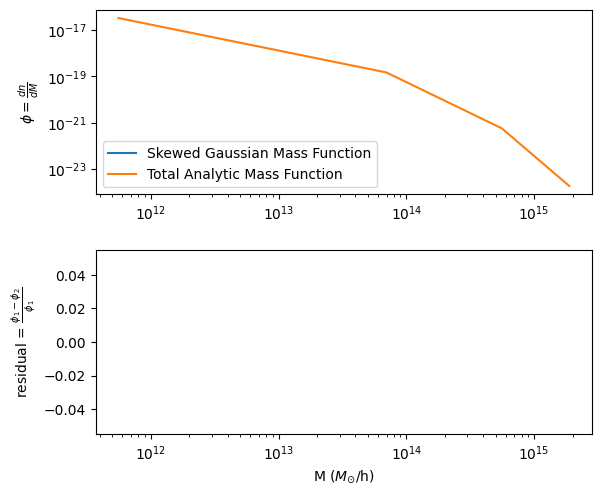

In [832]:
residual(v_mass[:-1], skew_rescale[:-1], v_bins[:-1], tot, "Skewed Gaussian Mass Function", "Total Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residual_total_v_skew.png")

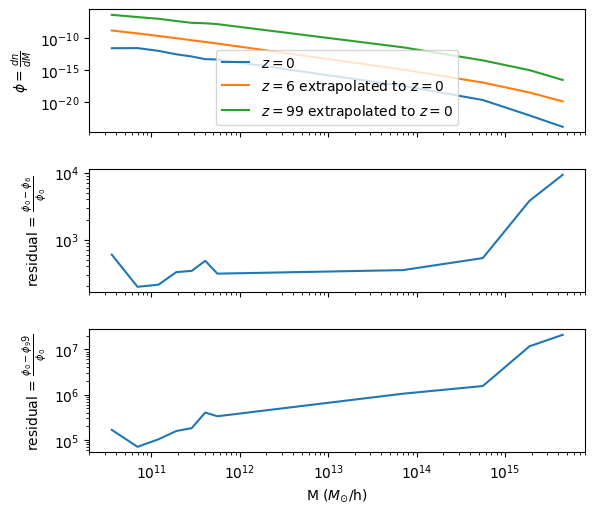

In [833]:
fig = plt.figure()

gs = fig.add_gridspec(3, 1)

fig1 = fig.add_subfigure(gs[0,0])
_mass_function(masses_r, ps_fit_r, label="$z = 0$", fig=fig1);
_mass_function(masses_r, ps_fit_6_r, label="$z = 6$ extrapolated to $z = 0$", fig=fig1);
_mass_function(masses_r, ps_fit_99_r, label="$z = 99$ extrapolated to $z = 0$", fig=fig1);

residual_0v6 = (ps_fit_r - ps_fit_6_r) / ps_fit_r
residual_0v99 = (ps_fit_r - ps_fit_99_r) / ps_fit_r

fig2 = fig.add_subfigure(gs[1,0])
fig3 = fig.add_subfigure(gs[2,0])

prev_ax=fig1.gca()
ax = fig2.add_subplot(sharex=prev_ax)

prev_ax.tick_params("x", labelbottom=False)
prev_ax.set_xlabel("")
ax.tick_params("x", labelbottom=False)

ax.plot(masses_r, abs(residual_0v6))
ax.set_xscale("log")
ax.set_yscale("log")

# ax.set_xlabel("M ($M_{\odot}$/h)")
ax.set_ylabel("residual = $\\frac{\phi_0-\phi_6}{\phi_0}$")

ax = fig3.add_subplot(sharex=prev_ax)
ax.plot(masses_r, abs(residual_0v99))
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("M ($M_{\odot}$/h)")
ax.set_ylabel("residual = $\\frac{\phi_0-\phi_99}{\phi_0}$")

fig.savefig("../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_z0_z6_z99.png", bbox_inches='tight')

In [834]:
d.config.radii

[0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 80,
 90,
 100]